<a href="https://colab.research.google.com/github/Tclack88/MountainProject/blob/master/rp_os_pyramids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redpoint/Onsight ladders

In [0]:
# Person being considered
document = "https://www.mountainproject.com/user/110296901/morgan-f/tick-export"

In [0]:
import pandas as pd
import numpy as np
from math import floor
from datetime import datetime as dt
import seaborn as sb
import matplotlib.pyplot as plt
sb.set(style='whitegrid')

In [0]:
# Get Grade for conversion (from Mountain Project's official grade converter)
grade_chart = pd.read_html("https://www.mountainproject.com/international-climbing-grades")
old_ropes = grade_chart[0].YDSUSA[:-1].to_list()
new_ropes = [0,0,0,0,1,2,3,4,5,6,7,7.4,8,8.4,8.8,9,9.4,9.8]+list(np.round(np.arange(10,16,.1),1))
ropes_convert = dict(zip(old_ropes,new_ropes))

In [0]:
# Supporting functions for clean and prep pipeline
def clean_grade(grade):
  grade = str(grade).split()[0]
  if grade[0] == '5':
    grade = ropes_convert[grade]
    return grade

def x_round(x):
  """ rounds down to nearest .25
  eg. x_round(11.49) = 11.25, x_round(11.51) = 11.5
  """
  if x >= 10:
    return floor(x*4)/4
  else: return x


# Rounding Key example:

# 10a, 10-, 10a/b  -> 10a
# 10b, 10          -> 10b
# 10b/c, 10c, 10+  -> 10c
# 10c/d, 10d       -> 10d

# def grade_to_number(grade):
#   letter_map = {'a':'.0', 'b':'.25', 'c':'.5', 'd':'.75', '-':'.0', '+':'.8'}
#   if grade[-1].isnumeric() == False:
#     grade = grade[:-1] + letter_map[grade[-1]]
#     print(grade)
#   else:
#     grade += '.4'
#     print(grade)


def grade_to_letter(grade):
  letter_map = {'.0':'a', '.25':'b', '.5':'c', '.75':'d'}
  letter_map_low = {'.0':'-', '.4':'', '.8':'+'}
  if grade >= 10:
    grade = str(grade)
    grade = grade[:2] + letter_map[grade[2:]]
    return grade
  else:
    grade = str(grade)
    grade = grade[:1] + letter_map_low[grade[1:]]
    return grade


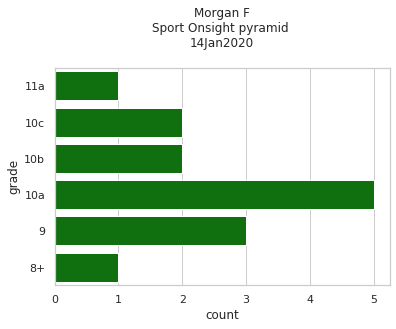

  grade  count
0   11a      1
1   10c      2
2   10b      2
3   10a      5
4     9      3
5    8+      1


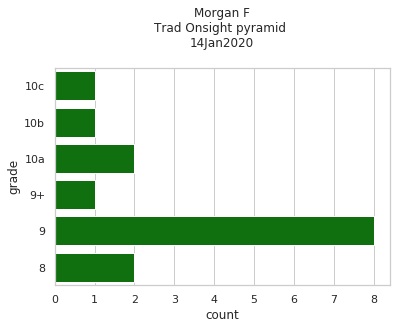

  grade  count
0   10c      1
1   10b      1
2   10a      2
3    9+      1
4     9      8
5     8      2


In [44]:
# document = "https://www.mountainproject.com/user/109791883/trevor-clack/tick-export"
# document = "https://www.mountainproject.com/user/110296901/morgan-f/tick-export"

climber = document.split('/')[-2].replace('-',' ').title()
date = dt.now().strftime('%-d%b%Y')
data = pd.read_csv(document)
data = data[['Route', 'Rating', 'Style', 'Lead Style', 'Route Type']]
data = data.rename(columns = (dict(zip(data.columns,['route', 'grade', 'style', 'lead_style', 'type']))))
data.grade = data.grade.apply(clean_grade)
data = data[data['style'] == 'Lead']
# Split Trad and Sport data
trad = data[(data['type'] == 'Trad') | (data['type'] == 'Trad, Sport') | (data['type'] == 'Trad, Alpine') | (data['type'] == 'Trad, Aid')]
sport = data[(data['type'] == 'Sport') | (data['type'] == 'Sport, TR')]
trad_rp = trad[trad.lead_style == 'Redpoint']
trad_os = trad[trad.lead_style == 'Onsight']
trad_os.grade.apply(x_round).value_counts().sort_index(ascending=False)
sport_rp = sport[sport.lead_style == 'Redpoint']
sport_os = sport[sport.lead_style == 'Onsight']


styles = [sport_os, sport_rp, trad_os, trad_rp]

for style in styles:
  if not style.empty:
    title = f"{climber}\n{style.iloc[0]['type'].split(',')[0]} {style.iloc[0].lead_style} pyramid \n{date}\n"
    top_pyramid = style.grade.apply(x_round).value_counts().sort_index(ascending=False).iloc[:6].reset_index()
    top_pyramid.columns = ('grade','count')
    top_pyramid.grade = top_pyramid.grade.apply(grade_to_letter)
    sb.barplot(y='grade', x='count', data=top_pyramid, color='green')
    plt.title(title)
    plt.show()
    print(top_pyramid)



In [45]:
successful_climbs = data[(data.lead_style == 'Redpoint') | (data.lead_style =='Onsight')]
successful_climbs.grade = successful_climbs.grade.apply(lambda x: grade_to_letter(x_round(x)))
successful_climbs_stack = successful_climbs[['grade','route']]
successful_climbs_stack

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,grade,route
1,10a,Little Red Book
2,10a,Easy Prey
3,11a,Hole In One
4,10a,Dream of Wild Turkeys
5,10b,Stolen Chimney
18,9,Crooked Dick Spire
19,10a,Holey Moley
24,10b,Ants Go Marching
27,9,Crag Rat
28,9,The Squamish Butt Face


## Combined redpoint and os pyramid

In [0]:
def make_pyramid(document):
  climber = document.split('/')[-2].replace('-',' ').title()
  date = dt.now().strftime('%-d%b%Y')
  data = pd.read_csv(document)
  data = data[['Route', 'Rating', 'Style', 'Lead Style', 'Route Type']]
  data = data.rename(columns = (dict(zip(data.columns,['route', 'grade', 'style', 'lead_style', 'type']))))
  data.grade = data.grade.apply(clean_grade)
  data = data[data['style'] == 'Lead']
  # Split Trad and Sport data
  trad = data[(data['type'] == 'Trad') | (data['type'] == 'Trad, Sport') | (data['type'] == 'Trad, Alpine') | (data['type'] == 'Trad, Aid')]
  sport = data[(data['type'] == 'Sport') | (data['type'] == 'Sport, TR')]
  trad_rp = trad[trad.lead_style == 'Redpoint']
  trad_os = trad[trad.lead_style == 'Onsight']
  trad_os.grade.apply(x_round).value_counts().sort_index(ascending=False)
  sport_rp = sport[sport.lead_style == 'Redpoint']
  sport_os = sport[sport.lead_style == 'Onsight']

  sport_combined = pd.concat([sport_rp,sport_os], axis=0)
  trad_combined = pd.concat([trad_rp, trad_os], axis=0)
  styles = [sport_combined, trad_combined]

  pyramids = []
  for style in styles:
    if not style.empty:
      title = f"{climber}\n{style.iloc[0]['type'].split(',')[0]} pyramid \n as of {date}\n"
      top_pyramid = style.grade.apply(x_round).value_counts().sort_index(ascending=False).iloc[:6].reset_index()
      top_pyramid.columns = ('grade','count')
      top_pyramid.grade = top_pyramid.grade.apply(grade_to_letter)
      sb.barplot(y='grade', x='count', data=top_pyramid, color='green')
      plt.title(title)
      plt.show()
      print(top_pyramid)
      print('\n\n\t\ttop 10')
      print(style.sort_values('grade',ascending=False).head(10))
      pyramids.append(top_pyramid)

  return pyramids

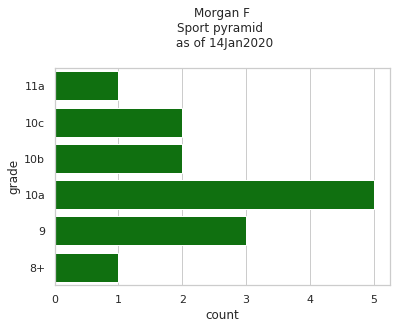

  grade  count
0   11a      1
1   10c      2
2   10b      2
3   10a      5
4     9      3
5    8+      1


		top 10
               route  grade style lead_style   type
3        Hole In One   11.0  Lead    Onsight  Sport
51        Lost Orbit   10.6  Lead    Onsight  Sport
68     One-Eyed Jack   10.6  Lead    Onsight  Sport
24  Ants Go Marching   10.3  Lead    Onsight  Sport
48            Hubble   10.3  Lead    Onsight  Sport
1    Little Red Book   10.0  Lead    Onsight  Sport
73   Change of Scene   10.0  Lead    Onsight  Sport
19       Holey Moley   10.0  Lead    Onsight  Sport
2          Easy Prey   10.0  Lead    Onsight  Sport
69         Easy Prey   10.0  Lead    Onsight  Sport


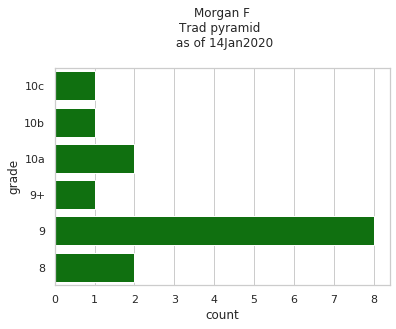

  grade  count
0   10c      1
1   10b      1
2   10a      2
3    9+      1
4     9      8
5     8      2


		top 10
                     route  grade style lead_style       type
29   The Squamish Buttress   10.6  Lead    Onsight       Trad
5           Stolen Chimney   10.4  Lead    Onsight  Trad, Aid
4    Dream of Wild Turkeys   10.0  Lead    Onsight       Trad
34          El Camino Real   10.0  Lead    Onsight       Trad
55          Igor Unchained    9.8  Lead    Onsight       Trad
31        St. Vitus' Dance    9.4  Lead    Onsight       Trad
36        Dave's Deviation    9.4  Lead    Onsight       Trad
42            Sexy Grandma    9.4  Lead    Onsight       Trad
28  The Squamish Butt Face    9.4  Lead    Onsight       Trad
60                Whodunit    9.4  Lead    Onsight       Trad


In [47]:
# document = "https://www.mountainproject.com/user/109791883/trevor-clack/tick-export"   # Trevor
# document = "https://www.mountainproject.com/user/110296901/morgan-f/tick-export"  # Morgan

sport_pyramid, trad_pyramid = make_pyramid(document)

## Make suggestions to "fill out" pyramid

In [48]:
# pros are usually 1, 3, 20, 50, 100 (based on 8a.nu)
# intermediate maybe 1, 3, 10, 20, 30
# 1 2 4 8 12 seems reasonable for a beginner


sport_pyramid

,grade,count
0,11a,1
1,10c,2
2,10b,2
3,10a,5
4,9,3
5,8+,1


In [0]:
grades_list = '0 1 2 3 4 5 6 7 7+ 8- 8 8+ 9- 9 9+'.split()

numbs = '10 11 12 13 14 15'.split()
letters =  list('abcd')
for i in numbs:
  for j in letters:
    grades_list.append(i+j)

def suggest_pyramid(pyramid):
  scheme = [1,2,4,8,12] # may need to pass in later or set as "class global"
  print(pyramid.copy().iloc[0].grade)
  top_index = grades_list.index(pyramid.grade[0]) + 1

  user_grade_count_dict = dict(zip(pyramid.grade, pyramid['count']))
  top_5_grades = grades_list[top_index : top_index - 5 : -1]
  top_5_count = [ user_grade_count_dict.get(grade,0) for grade in top_5_grades] # 2nd argument in .get() gives value to be returned if non-existent

  pyramid_copy = pd.DataFrame(zip(top_5_grades, top_5_count), columns = ['grade','count']).iloc[:5]
  pyramid_copy['ideal_count'] = scheme
  pyramid_copy['todo'] = pyramid_copy.ideal_count - pyramid_copy['count']
  pyramid_copy.todo = pyramid_copy.todo.apply(lambda x: 0 if (x < 1) else x) # negative numbers -> 0 
  print(pyramid_copy)

In [50]:
suggest_pyramid(sport_pyramid)

11a
  grade  count  ideal_count  todo
0   11b      0            1     1
1   11a      1            2     1
2   10d      0            4     4
3   10c      2            8     6
4   10b      2           12    10


In [52]:
## Scraping to make recommendations
url  = "https://www.mountainproject.com/area/classics/105865045/new-jack-city"
url = "https://www.mountainproject.com/area/classics/108189726/fairview-mountain"
import pandas as pd
import numpy as np
table = pd.read_html(url)[1]
table = table[table.Difficulty.str.startswith('5.')]
# grades
grades = table.Difficulty.apply(lambda x: x.split()[0])   # HAVE TO CONVERT TO LETTER GRADE ? :[
grades = grades.apply(lambda x: x_round(ropes_convert[x])).apply(grade_to_letter) # remove V grades, convert to simple grades
# routes
routes = table['Route Name'].apply(lambda x: ' '.join(x.split()[1:]))
# putting them together
recommendations_dict = {'grade':grades, 'route':routes}
recommendations_df = pd.DataFrame(recommendations_dict)

###################################################
#TEMP - make global/classvariable: assume we have user's 5 sought after grades: 
top_index = grades_list.index(sport_pyramid.grade[0]) + 1
user_grade_count_dict = dict(zip(sport_pyramid.grade, sport_pyramid['count']))
top_5_grades = grades_list[top_index : top_index - 5 : -1] # list of top grades as string
top_5_count = [ user_grade_count_dict.get(grade,0) for grade in top_5_grades] # 2nd argument in .get() gives value to be returned if non-existent
###################################################

recommendations_df = recommendations_df[recommendations_df.route.isin(successful_climbs_stack.route) == False] # returns area classics that haven't been climbed
recommendations_df[recommendations_df.grade.str.contains('|'.join(top_5_grades))][::-1].reset_index(drop=True) # returns the right grade range (| in the string will give an "or" effect)

,grade,route
0,11b,Clone Army
1,11a,Internet Superstar
2,11a,Little Fighter
3,11a,Dark Matter
4,11a,Solar Warrior Dynasty
5,10d,Light Saber
6,10d,Stretch Armstrong
7,10d,Mojave Green
8,10d,Jangofet
9,10c,Space Wrangler
